In [4]:
pip show  matplotlib fastapi uvicorn pillow python-multipart


Name: matplotlib
Version: 3.10.5
Summary: Python plotting package
Home-page: 
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib  alone or in any deri

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers, initializers

2025-08-28 15:18:54.529393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:18:54.572603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 15:18:55.520548: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

X_train = X_train.reshape(X_train.shape[0], -1)  # (60000, 784)
X_test  = X_test.reshape(X_test.shape[0], -1)


Y_train = to_categorical(y_train, 10)
Y_test  = to_categorical(y_test, 10)

print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)


Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [3]:
# 2- Model Builder Function

def build_model(layer_dims, init="he_normal", reg=None, dropout_rate=0.0):

    model = models.Sequential()

    model.add(layers.Dense(layer_dims[1], activation="relu",
                           kernel_initializer=init,
                           kernel_regularizer=reg,
                           input_shape=(layer_dims[0],)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

    # Hidden layers
    for i in range(2, len(layer_dims)-1):
        model.add(layers.Dense(layer_dims[i], activation="relu",
                               kernel_initializer=init,
                               kernel_regularizer=reg))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Output layer (softmax for classification)
    model.add(layers.Dense(layer_dims[-1], activation="softmax",
                           kernel_initializer=init,
                           kernel_regularizer=reg))

    # Compile with SGD 
    model.compile(optimizer="sgd",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [4]:
# 3- Initialization Experiments ( Zeros vs Random vs Xavier vs He )

inits = ["zeros", "random_normal", "glorot_normal", "he_normal"]
histories_init = {}
layer_dims = [784, 512, 256, 128, 10]


results_init = {}

for init in inits:
    print(f"Training with {init} initialization...")
    model = build_model(layer_dims, init=init)
    history = model.fit(X_train, Y_train, 
                        epochs=70, batch_size=128,
                        validation_data=(X_test, Y_test), 
                        verbose=0)
    histories_init[init] = history

    # Get final train & test accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_test_acc  = history.history['val_accuracy'][-1]

    results_init[init] = {
        "Train Acc": round(final_train_acc, 4),
        "Test Acc": round(final_test_acc, 4)
    }

# For Deployment
model.save("fashion_model_init.h5")



Training with zeros initialization...


/home/youssef/jupyterlab-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756383537.214510  149663 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1399 MB memory:  -> device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-08-28 15:18:57.782099: I external/local_xla/xla/service/service.cc:163] XLA service 0x78d1d4017110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-28 15:18:57.782113: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-08-28 15:18:57.795117: I tensorflow/compiler/mlir/tensorflow/utils/dump

Training with random_normal initialization...
Training with glorot_normal initialization...
Training with he_normal initialization...


               Train Acc  Test Acc
zeros             0.0985    0.1000
random_normal     0.9193    0.8792
glorot_normal     0.9281    0.8879
he_normal         0.9325    0.8886


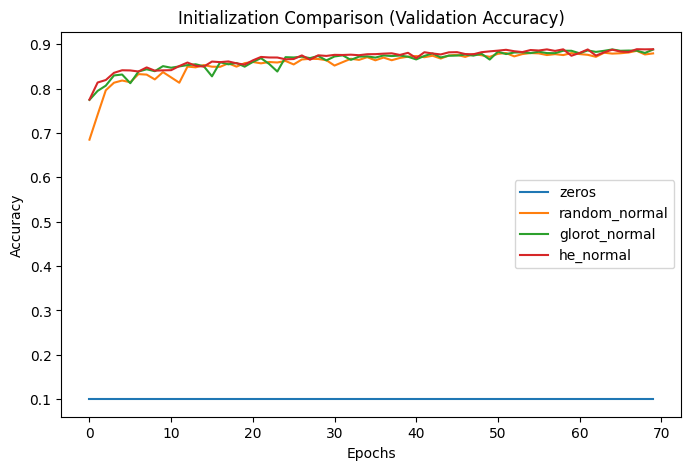

In [5]:
df_results = pd.DataFrame(results_init).T
print(df_results)


plt.figure(figsize=(8,5))
for init, history in histories_init.items():
    plt.plot(history.history['val_accuracy'], label=init)
plt.title("Initialization Comparison (Validation Accuracy)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [6]:
# 4- Regularization Experiments

configs = {
    "No Reg": {"reg": None, "dropout": 0.0},
    "L2": {"reg": regularizers.l2(0.005), "dropout": 0.0},
    "Dropout": {"reg": None, "dropout": 0.45}
}

histories_reg = {}

layer_dims = [784, 256, 128, 10] #dataset has 10 classifications


for name, cfg in configs.items():
    print(f"\nTraining with {name}...")
    model = build_model(layer_dims, init="he_normal", 
                        reg=cfg["reg"], 
                        dropout_rate=cfg["dropout"])
    
    history = model.fit(
        X_train, Y_train,
        epochs=150, batch_size=128,
        validation_data=(X_test, Y_test),
        verbose=0
    )
    
    histories_reg[name] = history
    
    # Print final training & test accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_test_acc = history.history['val_accuracy'][-1]
    print(f"{name} → Train Acc: {final_train_acc:.4f}, Test Acc: {final_test_acc:.4f}")

# For Deployment
model.save("fashion_model_reg.h5")


/home/youssef/jupyterlab-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training with No Reg...
No Reg → Train Acc: 0.9447, Test Acc: 0.8820

Training with L2...
L2 → Train Acc: 0.8612, Test Acc: 0.8428

Training with Dropout...


Dropout → Train Acc: 0.8944, Test Acc: 0.8883


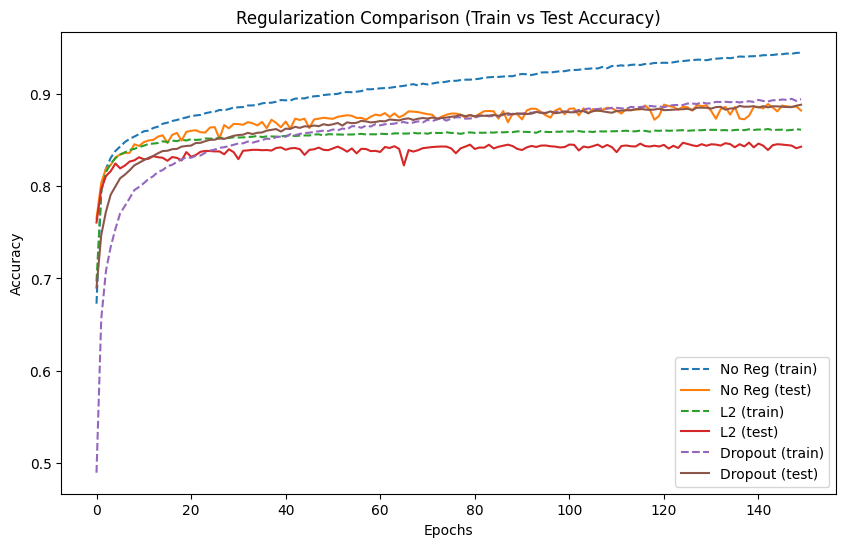

In [7]:
plt.figure(figsize=(10,6))
for name, history in histories_reg.items():
    plt.plot(history.history['accuracy'], linestyle="--", label=f"{name} (train)")
    plt.plot(history.history['val_accuracy'], label=f"{name} (test)")
plt.title("Regularization Comparison (Train vs Test Accuracy)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
